In [3]:
import os
import numpy as np
import matplotlib
import pandas as pd
import json
import argparse
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scienceplots
import wandb

In [157]:
path = "/Users/ericavandersar/surfdrive/Documents/Research/Results_SurveyPaper"
# Define all possible names and assign fixed colors
all_names = ["DoNothing", "Greedy", "PPO", "PPO*"]
fixed_palette = dict(zip(all_names, sns.color_palette("hls", len(all_names))))

# Make baselines training curves

## Gather data of baselines from WandB

In [4]:
project='Case14_SurveyPaper'
api = wandb.Api()
wandb_path = f"mahrl4grid2op/{project}"
print("Updating parameters in WandB Project: ", wandb_path)
runs = api.runs(f"mahrl4grid2op/{project}")
print(f"Matching runs: {len(runs)}")

# Filter runs where env_config.action_space == 'medha'
filtered_runs = [run for run in runs if run.config.get("env_config", {}).get("action_space") == "medha"]

print(f"Found {len(filtered_runs)} runs with env_config.action_space='medha'")

Updating parameters in WandB Project:  mahrl4grid2op/Case14_SurveyPaper
Matching runs: 45
Found 10 runs with env_config.action_space='medha'


In [137]:
def make_df_metrics(filtered_runs):
    df_list = []
    for run in filtered_runs:
        metrics_df = run.history()
        time_steps = metrics_df['timesteps_total']
        metrics_df = metrics_df.loc[:, metrics_df.columns.str.startswith('custom')]
        metrics_df['env_interactions'] = time_steps
        metrics_df.columns = metrics_df.columns.str.replace('custom_metrics/', '')
        metrics_df['name'] = "PPO*" if run.config.get('opponent') else "PPO"
        df_list.append(metrics_df)
    
    df = pd.concat(df_list, ignore_index=True)
    return df

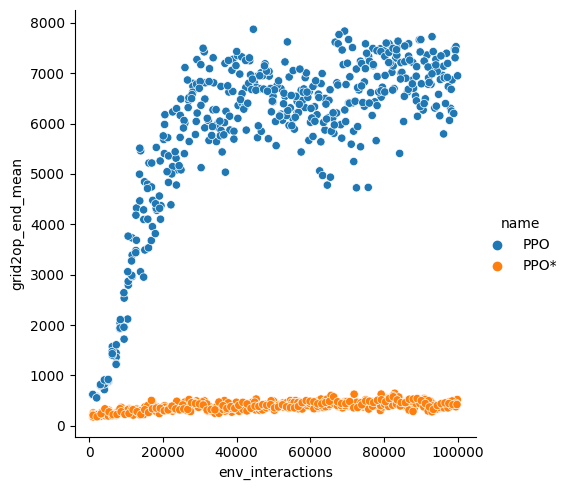

In [74]:
sns.relplot(x="env_interactions", y="grid2op_end_mean", hue="name", data=df)
plt.show()

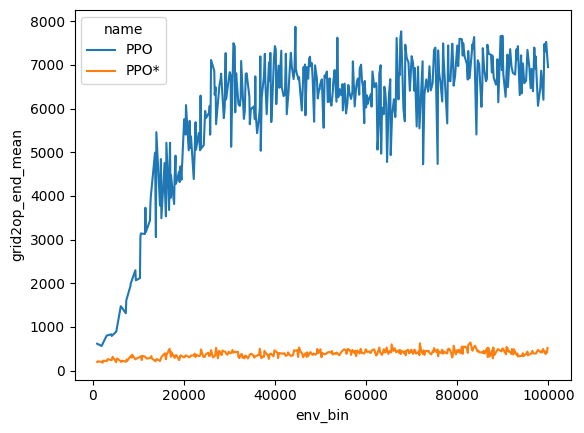

In [72]:
sns.lineplot(x="env_bin", y="grid2op_end_mean", hue="name", data=df_smoothed)
plt.show()

## make the plot

In [163]:
max_env_steps = 8064
# Define the bin width for grouping (adjust this based on your data range)
bin_width = 1500

def make_training_curve(df, header, max_env_steps=8064, bin_width=1500, palette=None):
    
    # Create bins for 'env_interactions'
    df['env_bin'] = (df['env_interactions'] // bin_width) * bin_width
    
    # Aggregate data by bins and name
    aggregated = df.groupby(['env_bin', 'name']).agg({
        'grid2op_end_mean': ['mean', 'std'],  # Mean and standard deviation
        'env_interactions': 'mean'  # Bin center
    }).reset_index()
    
    # Flatten the MultiIndex columns
    aggregated.columns = ['env_bin', 'name', 'mean', 'std', 'env_interactions']
    
    # Style
    # Set up a color palette
    if palette is None:
        palette = sns.color_palette("hls",len(df.name.unique()))
    style = ['science', 'grid', 'no-latex']
    plt.style.use(style)
    # Size
    plt.figure(figsize=(8, 6))
    ax = plt.gca()
    
    # Plot with Seaborn
    sns.lineplot(
        x="env_interactions",
        y="mean",
        hue="name",
        data=aggregated,
        palette=palette,
        ax=ax,
        # marker="o",
    )
    
    # Add the shaded area for std
    for i, (name, group) in enumerate(aggregated.groupby('name')):
        plt.fill_between(
            group['env_interactions'],
            group['mean'] - group['std'],
            group['mean'] + group['std'],
            alpha=0.1,
            color=palette[name]
        )
    plt.title(label=header, fontsize=20, fontweight="bold")
    plt.ticklabel_format(style="sci", axis="x", scilimits=(3, 3))
    plt.legend(fontsize=14)
    plt.ylim(ymin=0, ymax=max_env_steps+100)
    # plt.xlim(xmin=0, xmax=100_000)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Environment interactions', fontsize=16)
    plt.ylabel('Time steps survived', fontsize=16)
    plt.legend(fontsize=14, bbox_to_anchor=(1, 1),
        loc='upper left') #, title="Agents",title_fontsize=16)
    return plt

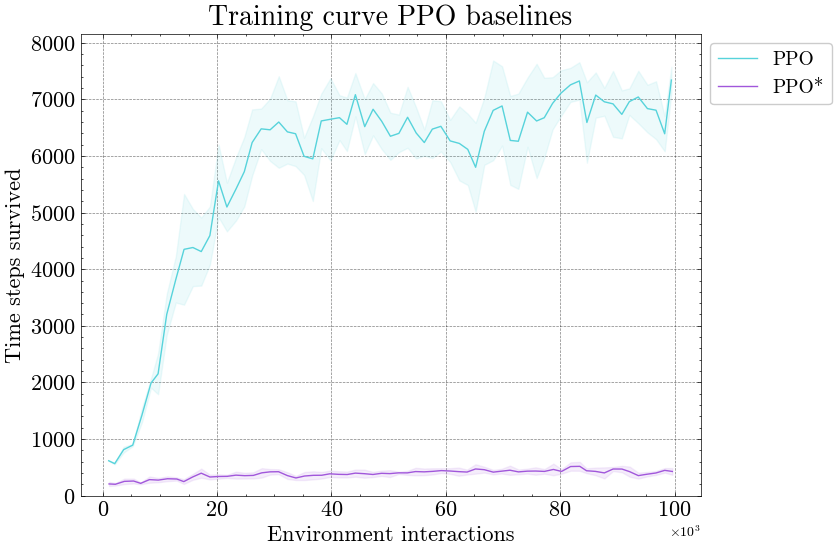

In [164]:
plt = make_training_curve(df, header="Training curve PPO baselines", palette=fixed_palette)
plt.savefig(os.path.join(path, f'Traincurve_BaselineAgents.svg'))

In [131]:
project='Case14_Opponent'
api = wandb.Api()
wandb_path = f"mahrl4grid2op/{project}"
print("Updating parameters in WandB Project: ", wandb_path)
runs_opp = api.runs(f"mahrl4grid2op/{project}")
print(f"Matching runs: {len(runs_opp)}")

# Filter runs where env_config.action_space == 'medha'
filtered_runs_opp = [run for run in runs_opp if run.config.get("env_config", {}).get("action_space") == "medha"]

print(f"Found {len(filtered_runs_opp)} runs with env_config.action_space='medha'")

Updating parameters in WandB Project:  mahrl4grid2op/Case14_Opponent
Matching runs: 10
Found 5 runs with env_config.action_space='medha'


In [138]:
df_opp = make_df_metrics(filtered_runs_opp)
df_opp

,mean_reconnect_count,mean_interact_count,grid2op_end_std,mean_active_dn_count,grid2op_end_mean,corrected_ep_len_mean,mean_reset_count,env_interactions,name
0,1,2,37271.248748,0,173,173,0,1137,PPO*
1,1,2,55624.774760,0,226,226,0,2311,PPO*
2,1,2,68550.918208,0,262,262,0,3398,PPO*
3,2,3,64223.592683,0,315,315,0,4454,PPO*
4,1,3,63268.001084,0,271,271,0,5534,PPO*
...,...,...,...,...,...,...,...,...,...
2322,3,4,85384.910593,0,459,459,0,494872,PPO*
2323,2,4,94762.342045,1,407,407,0,495905,PPO*
2324,3,4,108076.683541,0,450,450,0,496957,PPO*
2325,3,4,106595.149954,0,449,449,0,498040,PPO*


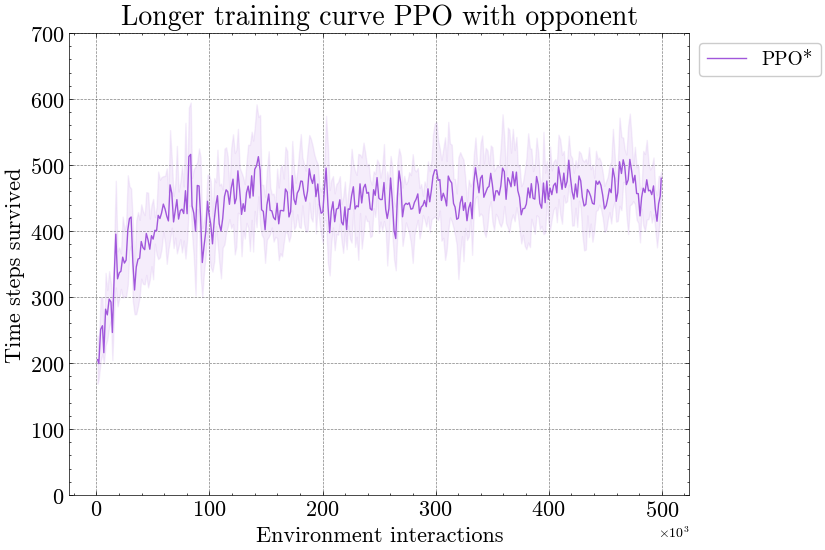

In [165]:
path = "/Users/ericavandersar/surfdrive/Documents/Research/Results_SurveyPaper"
palette = sns.color_palette("hls")
plt = make_training_curve(df_opp, header="Longer training curve PPO with opponent", max_env_steps=600, palette=fixed_palette)
plt.savefig(os.path.join(path, f'Traincurve_BaselineAgents_OppLong.svg'))